In [1]:
# Imports
import time
import os
import glob
import csv
import numpy as np
import pandas as pd
from scipy import stats
import openai
import matplotlib.pyplot as plt
import seaborn as sns

# File locations
dir = '/Users/Federica_1/Documents/GitHub/endoQAeval'
out_dir = os.path.join(dir, 'output')
fig_dir = os.path.join(dir, 'figures')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Statistical Testing of Difference in Information Quality, Empathy, and Actionability between Answers to Endo vs General Questions

In [2]:
# some preprocessing to combine annotation datasets
pat = pd.read_csv(os.path.join(out_dir, 'patient_annotations.csv'), usecols=range(4,13))
doc = pd.read_csv(os.path.join(out_dir, 'specialist_annotations.csv'), usecols=range(4,8))
merged = pd.merge(left=pat, left_on=['response_id', 'prompt', 'type'], right=doc, right_on=['response_id', 'prompt', 'type'])

for column in ["Information Quality","Empathy","Actionability"]:
    key_pat = f'Patient Average {column}'
    key2 = f'Annotator 2 - {column}'
    key3 = f'Annotator 3 - {column}'
    merged[key_pat] = merged[[key2, key3]].mean(axis=1)

column = "Information Quality"
key_all = f'Average {column}'
key1 = f'Specialist - {column}'
key2 = f'Annotator 2 - {column}'
key3 = f'Annotator 3 - {column}'
merged[key_all] = merged[[key1, key2, key3]].mean(axis=1)

print(len(pat))
print(len(doc))

merged[:1]

388
388


,response_id,prompt,type,Annotator 2 - Information Quality,Annotator 2 - Empathy,Annotator 2 - Actionability,Annotator 3 - Information Quality,Annotator 3 - Empathy,Annotator 3 - Actionability,Specialist - Information Quality,Patient Average Information Quality,Patient Average Empathy,Patient Average Actionability,Average Information Quality
0,endoR0,no_prompt,endo,4,2,2,3,2,2,4,3.5,2.0,2.0,3.666667


In [3]:
endo = merged[(merged['type'] == 'endo') & (merged['prompt'] == 'no_prompt')]
general = merged[(merged['type'] == 'general') & (merged['prompt'] == 'no_prompt')]

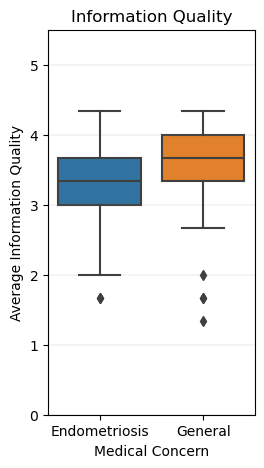

In [4]:
plt.figure(figsize=(8/3, 5))
ax = sns.boxplot(data=merged[merged['prompt'] == 'no_prompt'], x="type", y="Average Information Quality")
plt.ylim(0,5.5)
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_xticklabels(['Endometriosis', 'General'])
ax.set_xlabel('Medical Concern')
ax.set_ylabel('Average Information Quality')
plt.title(f'Information Quality')
plt.savefig(os.path.join(fig_dir, f'endovsgen.png'), dpi = 300, bbox_inches = "tight")
plt.show()

### Information Quality averaged across three annotators

In [5]:
stats.mannwhitneyu(endo['Average Information Quality'].values, general['Average Information Quality'].values, alternative='two-sided')

MannwhitneyuResult(statistic=3630.0, pvalue=0.005153664983629505)

In [6]:
stats.wilcoxon(endo['Average Information Quality'].values, general['Average Information Quality'].values, alternative='two-sided')

WilcoxonResult(statistic=1353.0, pvalue=0.017158363472872282)

# Endo vs General: Patient Ratings

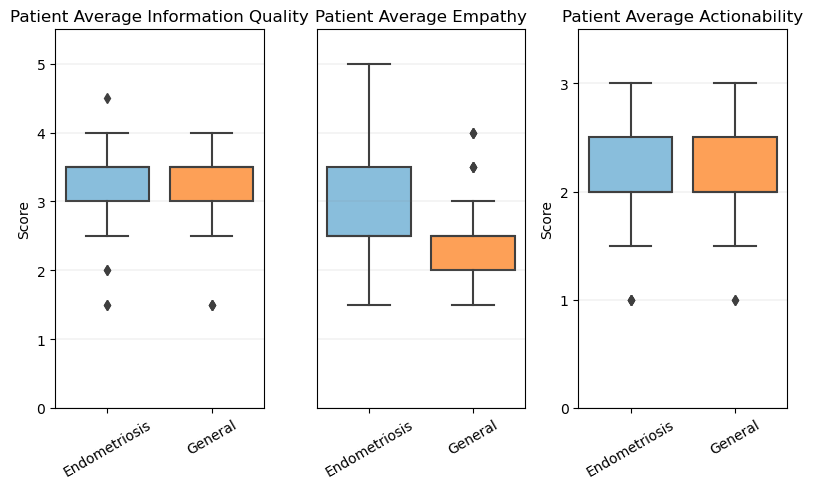

In [7]:
_figure = plt.figure(figsize = (8,5), tight_layout=0.5)
# plt.suptitle(f'Information Quality for Endomentriosis vs General\nResponses According to {annotator_type}', size=15)
pos = 1

for metric in ["Patient Average Information Quality","Patient Average Empathy","Patient Average Actionability"]:

    _figure.add_subplot(1,3,pos)
    data = merged[merged['prompt'] == 'no_prompt']

    ax = sns.boxplot(data=data, x='type', y=metric)
    
    box1 = ax.patches[0]
    box1.set_facecolor(sns.color_palette('Blues')[2])   
    box2 = ax.patches[1]
    box2.set_facecolor(sns.color_palette('Oranges')[2])

    ax.set_xticklabels(['Endometriosis', 'General'])
    ax.set_xlabel('Response Type')
    ax.tick_params(axis='x', labelrotation=30)
    ax.set_xlabel(f'')
    ax.set_ylim(0,5.5)

    if pos == 2:
        ax.set_ylabel('')
        ax.yaxis.set_tick_params(color='white')
        ax.set_yticklabels([])

    else:
        ax.set_ylabel(f'Score')

    if pos == 3:
        ax.set_ylim(0,3.5)
        ax.set_yticks([0,1,2,3])
    
    ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
    plt.title(f'{metric}')
    pos += 1

_figure.savefig(os.path.join(fig_dir, f'endovsgen_patients.png'), dpi = 300, bbox_inches = "tight")

## Stats

### Information Quality

In [8]:
stats.mannwhitneyu(endo['Patient Average Information Quality'].values, general['Patient Average Information Quality'].values, alternative='two-sided')

MannwhitneyuResult(statistic=4442.0, pvalue=0.4869515862092406)

In [9]:
stats.wilcoxon(endo['Patient Average Information Quality'].values, general['Patient Average Information Quality'].values, alternative='two-sided')

WilcoxonResult(statistic=1190.5, pvalue=0.477420893979962)

### Empathy

In [10]:
stats.mannwhitneyu(endo['Patient Average Empathy'].values, general['Patient Average Empathy'].values, alternative='two-sided')

MannwhitneyuResult(statistic=5614.0, pvalue=0.013773931653087056)

In [11]:
stats.wilcoxon(endo['Patient Average Empathy'].values, general['Patient Average Empathy'].values, alternative='two-sided')

WilcoxonResult(statistic=799.0, pvalue=0.003371616137229375)

### Actionability

In [12]:
stats.mannwhitneyu(endo['Patient Average Actionability'].values, general['Patient Average Actionability'].values, alternative='two-sided')

MannwhitneyuResult(statistic=4983.0, pvalue=0.42933005943376856)

In [13]:
stats.wilcoxon(endo['Patient Average Actionability'].values, general['Patient Average Actionability'].values, alternative='two-sided')

WilcoxonResult(statistic=999.0, pvalue=0.7770474009161459)

# Endo vs General: Specialist Rating

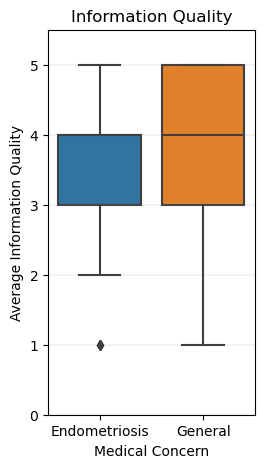

In [14]:
plt.figure(figsize=(8/3, 5))
ax = sns.boxplot(data=doc[doc['prompt'] == 'no_prompt'], x="type", y="Specialist - Information Quality")
plt.ylim(0,5.5)
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_xticklabels(['Endometriosis', 'General'])
ax.set_xlabel('Medical Concern')
ax.set_ylabel('Average Information Quality')
plt.title(f'Information Quality')
plt.savefig(os.path.join(fig_dir, f'endovsgen_specialist.png'), dpi = 300, bbox_inches = "tight")
plt.show()

### Chi-squared Test

In [15]:
def create_contingency_table(data, column):
    
    count_info_d = {'endo':[], 'general':[]}

    for concern in ['endo', 'general']:
        df = data[(data['type'] == concern) & (data['prompt'] == 'no_prompt')]
        count_info_d[concern].append(len(df))

        for score in sorted(df[column].unique(), reverse=True):
            count = len(df[df[column] == score])
            count_info_d[concern].append(count)

    labels = ['Total'] + [f'Score {str(x)}' for x in sorted(df[column].unique(), reverse=True)]
    print(count_info_d)
    counts = pd.DataFrame(count_info_d, index=labels)
    
    return counts

In [16]:
create_contingency_table(merged, 'Specialist - Information Quality')

{'endo': [97, 10, 39, 32, 13, 3], 'general': [97, 31, 38, 19, 7, 2]}


,endo,general
Total,97,97
Score 5,10,31
Score 4,39,38
Score 3,32,19
Score 2,13,7
Score 1,3,2


In [17]:
res = stats.chi2_contingency(counts)
print(f'Statistic: {res.statistic}', f'P-Value: {res.pvalue}', res.dof, '\n', res.expected_freq)

NameError: name 'counts' is not defined

### Stats

In [18]:
stats.mannwhitneyu(endo['Specialist - Information Quality'].values, general['Specialist - Information Quality'].values, alternative='two-sided')

MannwhitneyuResult(statistic=3314.5, pvalue=0.00019329769974871488)

In [19]:
stats.wilcoxon(endo['Specialist - Information Quality'].values, general['Specialist - Information Quality'].values, alternative='two-sided')

WilcoxonResult(statistic=808.0, pvalue=0.0012659791867267226)

# Bootstrapping

In [2]:
def bootstrap(dataslice):

  # Bootstrap calculations
  trials = 1000
  bootstrapped_means = []
  k = len(dataslice)
  for i in range(trials):
    sample = dataslice.sample(n=k, replace=True)
    mean = sample.mean()
    bootstrapped_means.append(mean)

  sort = sorted(bootstrapped_means)
  low = sort[int(trials*0.025)]
  high = sort[int(trials*0.975)]

  return low, high

In [ ]:
no_prompt = merged[merged['prompt'] == 'no_prompt'].copy()

In [23]:
for annotator in ['Average ', 'Specialist - ', 'Patient Average ']:
    for metric in ["Information Quality", "Empathy", "Actionability"]:
        for res_type in ['endo', 'general']:
            df = no_prompt[(no_prompt['type']==res_type)]
            key = annotator+metric
            if key in df.columns:
                values = df[key]
                mean = values.mean()
                ci_low, ci_high = bootstrap(df[key])
                if res_type == 'endo':
                    print(res_type, '\t\t', annotator+metric, '\t', round(mean, 2), f'[{round(ci_low,2)}, {round(ci_high,2)}]')
                else:
                    print(res_type, '\t', annotator+metric, '\t', round(mean, 2), f'[{round(ci_low,2)}, {round(ci_high,2)}]')

endo 		 Average Information Quality 	 3.31 [3.19, 3.42]
general 	 Average Information Quality 	 3.51 [3.4, 3.62]
endo 		 Specialist - Information Quality 	 3.41 [3.22, 3.61]
general 	 Specialist - Information Quality 	 3.92 [3.74, 4.13]
endo 		 Patient Average Information Quality 	 3.25 [3.14, 3.36]
general 	 Patient Average Information Quality 	 3.3 [3.19, 3.4]
endo 		 Patient Average Empathy 	 2.79 [2.64, 2.94]
general 	 Patient Average Empathy 	 2.49 [2.4, 2.59]
endo 		 Patient Average Actionability 	 2.12 [2.04, 2.21]
general 	 Patient Average Actionability 	 2.09 [2.02, 2.17]


In [22]:
for t in ['endo', 'general']:
    total = len(no_prompt[(no_prompt['type'] == t)])
    slice = len(no_prompt[(no_prompt['type'] ==t)&(no_prompt['Patient Average Empathy']< 4)])
    print(f'perc of non empathetic responses in {t} responses', round(slice/total, 2))

perc of non empathetic responses in endo responses 0.85
perc of non empathetic responses in general responses 0.97


# Qualitative Analysis

In [23]:
endo = merged[(merged['type'] == 'endo') & (merged['prompt'] == 'no_prompt')]['Specialist - Information Quality'].values
general = merged[(merged['type'] == 'general') & (merged['prompt'] == 'no_prompt')]['Specialist - Information Quality'].values